In [150]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

Data shape: (504, 224, 512)
Height: 504, Channels: 224, Width: 512
First few values of the cube:
[[[  336 10563   173   167   167]
  [  147   138   151   164   177]
  [  164   158   150   160   161]
  ...
  [  267   266   230   232   241]
  [  253   254   227   226   224]
  [  254   259   246   239   228]]

 [[58944 17542   215   215   216]
  [  209   205   212   214   212]
  [  212   211   209   210   214]
  ...
  [  329   327   288   286   278]
  [  310   307   277   277   279]
  [  306   301   264   268   273]]

 [[ 9088 18616   218   218   218]
  [  208   210   213   214   216]
  [  213   216   211   213   212]
  ...
  [  325   326   284   283   277]
  [  304   303   275   274   273]
  [  300   293   276   276   274]]

 ...

 [[  336 10563   202   205   210]
  [  206   200   207   207   208]
  [  210   207   208   209   210]
  ...
  [  340   337   252   250   243]
  [  327   322   240   239   241]
  [  318   314   234   236   239]]

 [[  336 10563   211   211   214]
  [  206   206 

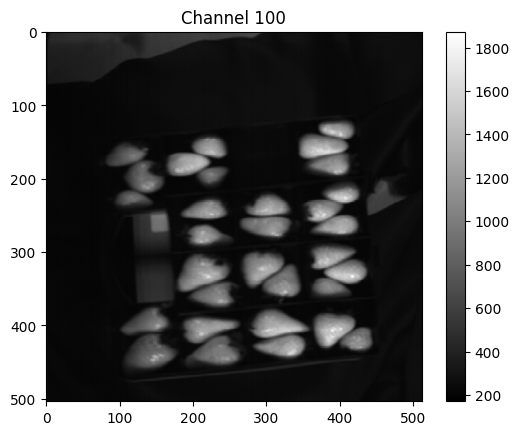

Maximum value in the cube: 64128
Minimum value in the cube: 137


In [151]:
# Load the .npy file
cube_data = np.load("data_cubes/data_cube_20250507_165419.npy")

# Ensure the data is 3D
if cube_data.ndim != 3:
    raise ValueError("The loaded .npy file must contain a 3D array.")

# Print the shape of the data (height, channel, width)
print(f"Data shape: {cube_data.shape}")
# Get the dimensions of the cube
height, channels, width = cube_data.shape
# Print the dimensions
print(f"Height: {height}, Channels: {channels}, Width: {width}")

# print the first few values of all columns the cube
print("First few values of the cube:")
print(cube_data[:, :, :5])
# Plot the first slice of the cube
plt.imshow(cube_data[:, 100, :], cmap='gray')
plt.title("Channel 100")
plt.colorbar()
plt.show()

max_value = np.max(cube_data)
print(f"Maximum value in the cube: {max_value}")
min_value = np.min(cube_data)
print(f"Minimum value in the cube: {min_value}")



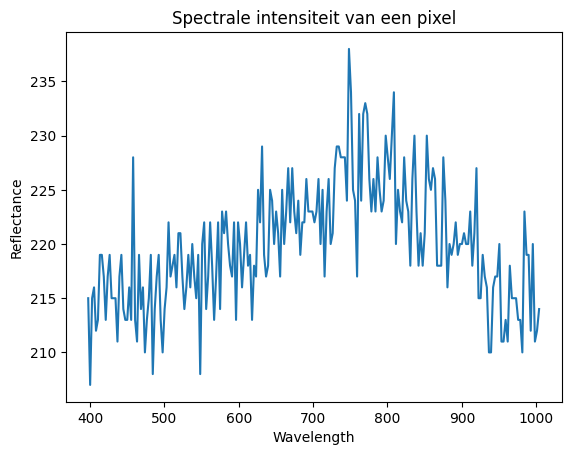

In [152]:
# Extract a single pixel's spectral data
pixel_y = 164
pixel_x = 146

pixel_data = cube_data[
    pixel_y:pixel_y+1,
    :,
    pixel_x:pixel_x+1
]

pixel_data_squeezed = np.squeeze(pixel_data)

# Generate a range of bands for plotting
bands = np.genfromtxt('bands.csv', delimiter=',')


plt.plot(bands, pixel_data_squeezed)
plt.title('Spectrale intensiteit van een pixel')
plt.xlabel('Wavelength')
plt.ylabel('Reflectance')
plt.show()

In [153]:
import sklearn
sklearn.show_versions()


System:
    python: 3.10.16 | packaged by Anaconda, Inc. | (main, Dec 11 2024, 16:19:12) [MSC v.1929 64 bit (AMD64)]
executable: c:\Users\moust\miniconda3\envs\hsi_env\python.exe
   machine: Windows-10-10.0.26100-SP0

Python dependencies:
      sklearn: 1.6.1
          pip: 25.0
   setuptools: 75.8.0
        numpy: 2.1.3
        scipy: 1.15.2
       Cython: None
       pandas: None
   matplotlib: 3.10.1
       joblib: 1.4.2
threadpoolctl: 3.6.0

Built with OpenMP: True

threadpoolctl info:
       user_api: blas
   internal_api: openblas
    num_threads: 12
         prefix: libscipy_openblas
       filepath: C:\Users\moust\miniconda3\envs\hsi_env\Lib\site-packages\numpy.libs\libscipy_openblas64_-c16e4918366c6bc1f1cd71e28ca36fc0.dll
        version: 0.3.27
threading_layer: pthreads
   architecture: Haswell

       user_api: blas
   internal_api: openblas
    num_threads: 12
         prefix: libscipy_openblas
       filepath: C:\Users\moust\miniconda3\envs\hsi_env\Lib\site-packages\scipy

In [154]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import spectral as spy
import matplotlib.patches as mpatches


In [155]:
import os
import numpy as np
from datetime import datetime

data_dir = "data_cubes" 

# List all .npy files
files = [f for f in os.listdir(data_dir) if f.endswith(".npy")]

# Extract timestamps and sort files
def extract_datetime(filename):
    dt_str = filename.split('_')[2] + filename.split('_')[3].split('.')[0]  # '20250507' + '165003'
    return datetime.strptime(dt_str, "%Y%m%d%H%M%S")

files_sorted = sorted(files, key=extract_datetime)

# Load the data cubes in time order
data_cubes = [np.load(os.path.join(data_dir, f)) for f in files_sorted]
timestamps = [extract_datetime(f) for f in files_sorted]


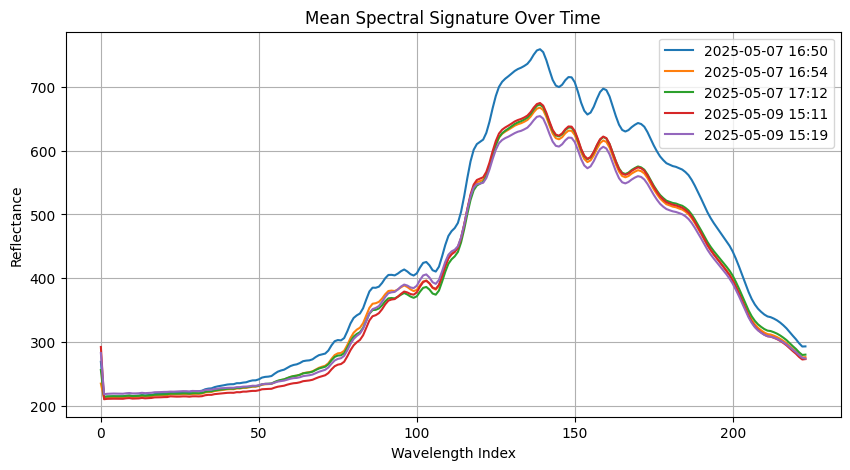

In [156]:
import matplotlib.pyplot as plt

# Compute mean spectrum for each cube
mean_spectra = [np.mean(cube, axis=(0, 2)) for cube in data_cubes] 

# Plot each spectrum
plt.figure(figsize=(10, 5))
for i, spectrum in enumerate(mean_spectra):
    plt.plot(spectrum, label=timestamps[i].strftime('%Y-%m-%d %H:%M'))
plt.legend()
plt.title('Mean Spectral Signature Over Time')
plt.xlabel('Wavelength Index')
plt.ylabel('Reflectance')
plt.grid(True)
plt.show()


In [157]:
for i, spectrum in enumerate(data_cubes):
    print(f"Spectrum {i} shape: {spectrum.shape}")

Spectrum 0 shape: (512, 224, 512)
Spectrum 1 shape: (504, 224, 512)
Spectrum 2 shape: (365, 224, 1024)
Spectrum 3 shape: (802, 224, 512)
Spectrum 4 shape: (496, 224, 512)


In [158]:
def generate_rgb_composite(data_cube, bands, red_range=(620, 750), green_range=(495, 570), blue_range=(450, 495)):
    """
    Generate an RGB composite image from a data cube using specified wavelength ranges.

    Parameters:
    - data_cube (numpy.ndarray): The input 3D data cube.
    - bands (numpy.ndarray): Array of band wavelengths to map to.
    - red_range (tuple): Wavelength range for the red channel (default: (620, 750)).
    - green_range (tuple): Wavelength range for the green channel (default: (495, 570)).
    - blue_range (tuple): Wavelength range for the blue channel (default: (450, 495)).

    Returns:
    - rgb_composite (numpy.ndarray): The generated RGB composite image.
    """
    # Find the indices of the bands that correspond to the wavelength ranges
    red_band = np.argmin(np.abs(bands - np.mean(red_range)))
    green_band = np.argmin(np.abs(bands - np.mean(green_range)))
    blue_band = np.argmin(np.abs(bands - np.mean(blue_range)))

    # Stack the selected bands into an RGB image
    rgb = np.stack([data_cube[:, red_band, :], data_cube[:, green_band, :], data_cube[:, blue_band, :]], axis=-1)

    # Normalize each channel separately
    rgb_norm = rgb - rgb.min(axis=(0, 1), keepdims=True)
    rgb_norm = rgb_norm / rgb_norm.max(axis=(0, 1), keepdims=True)

    # Apply gamma correction
    gamma = 1.5
    rgb_composite = np.power(rgb_norm, 1 / gamma)

    return rgb_composite


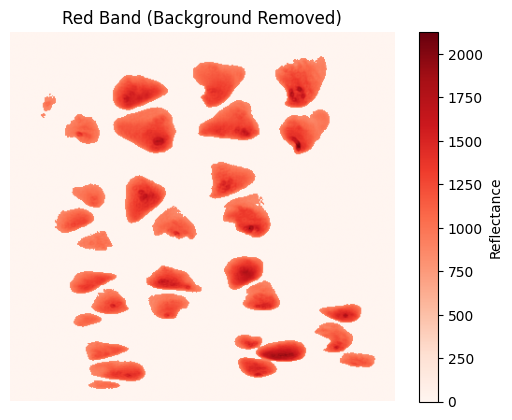

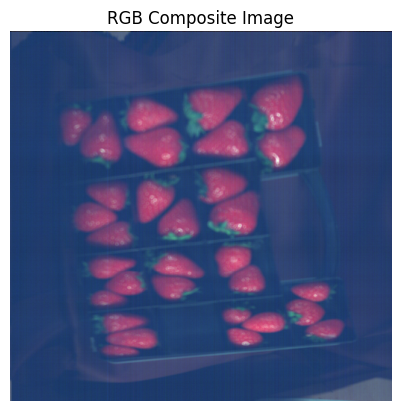

In [159]:
def process_band(data_cube, bands, band_range, crop_margin=50):
    """
    Process a specific band from the data cube by cropping, thresholding, and removing the background.

    Parameters:
    - data_cube (numpy.ndarray): The input 3D data cube.
    - bands (numpy.ndarray): Array of band wavelengths.
    - band_range (tuple): The wavelength range for the desired band (e.g., (620, 750) for red).
    - crop_margin (int): The margin to crop from the edges of the data cube.

    Returns:
    - processed_band (numpy.ndarray): The processed band with background removed.
    """
    # Crop the data cube to focus on the central region
    height, width = data_cube.shape[0], data_cube.shape[2]
    cropped_data_cube = data_cube[crop_margin:height-crop_margin, :, crop_margin:width-crop_margin]

    # Find the index of the desired band
    band_index = np.argmin(np.abs(bands - np.mean(band_range)))
    band_data = cropped_data_cube[:, band_index, :]

    # Dynamically calculate a threshold based on the data range
    threshold = band_data.mean() + band_data.std()  # Mean + 1 standard deviation
    binary_mask = band_data > threshold

    # Apply the mask to remove the background
    processed_band = np.where(binary_mask, band_data, 0)

    return processed_band

# Example usage
data_cube = np.load("data_cubes\data_cube_20250509_151914.npy")  # Load your data cube
bands = np.genfromtxt('bands.csv', delimiter=',')  # Load the bands
red_range = (620, 750)  # Define the wavelength range for red

red_band_data_no_background = process_band(data_cube, bands, red_range)
rgb_composite = generate_rgb_composite(data_cube, bands)


# Display the result
plt.imshow(red_band_data_no_background, cmap='Reds')
plt.title("Red Band (Background Removed)")
plt.colorbar(label="Reflectance")
plt.axis("off")
plt.show()

# Display the RGB composite image
plt.imshow(rgb_composite)
plt.title("RGB Composite Image")
plt.axis("off")
plt.show()




# # Show the red_band_data_no_background numpy array
# print(red_band_data_no_background)
# # Save the modified data cube
# output_filename = "red_band_data_no_background.npy"
# np.save(output_filename, red_band_data_no_background)

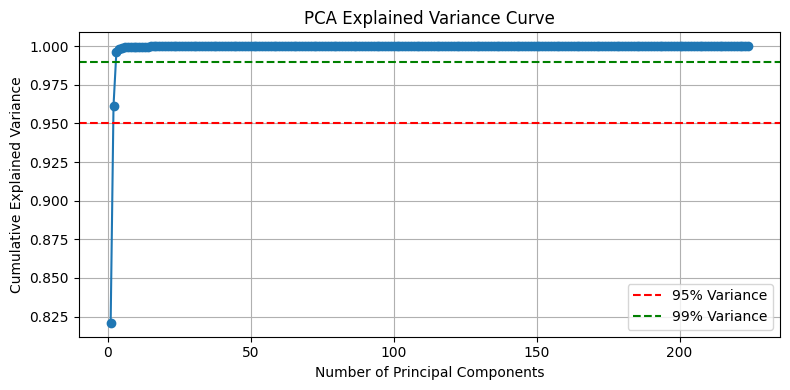

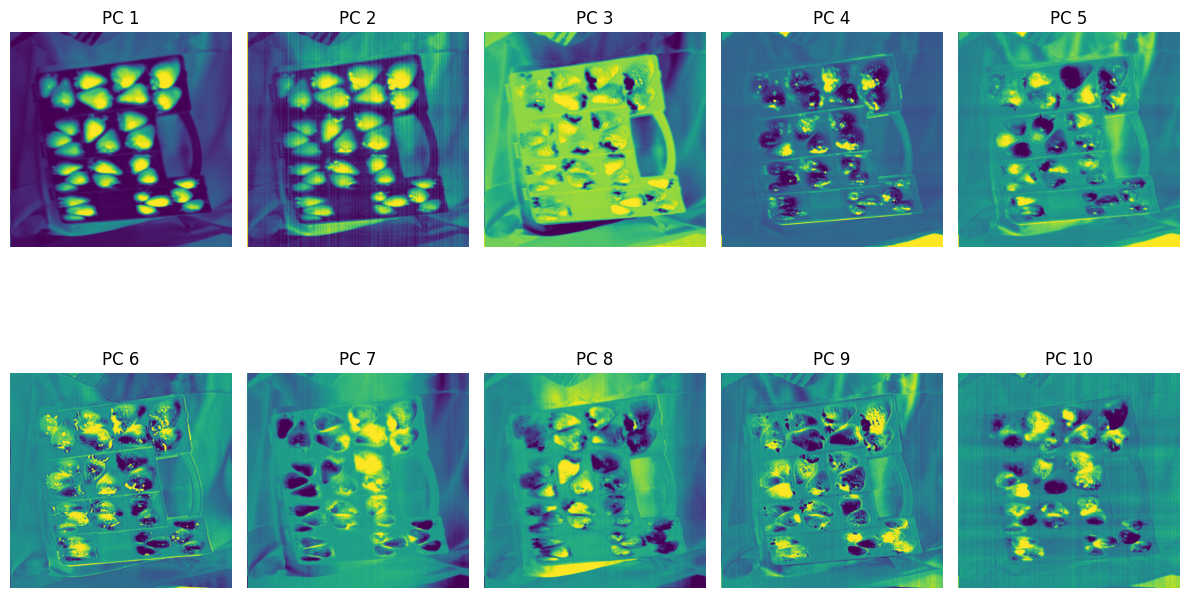

In [160]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os

# === Load the Hyperspectral Data Cube ===
data_path = "data_cubes/data_cube_20250509_151914.npy"
hsi_data = np.load(data_path)


# === Reshape the Cube to 2D (pixels x bands) ===
h, bands, w = hsi_data.shape
reshaped_data = hsi_data.transpose(1, 0, 2).reshape(bands, -1).T  # (height * width, bands)
reshaped_data = reshaped_data.astype(np.float64)

# === Normalize the Data ===
reshaped_data -= np.mean(reshaped_data, axis=0)

# === PCA Variance Analysis ===
pca_full = PCA()
pca_full.fit(reshaped_data)
explained_variance = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(8, 4))
plt.plot(np.arange(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.axhline(y=0.99, color='g', linestyle='--', label='99% Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Choose Number of Components Based on Explained Variance ===
num_components = 10

# === Apply PCA ===
pca = PCA(n_components=num_components)
pca_result = pca.fit_transform(reshaped_data)  # (pixels, components)

# === Reshape Back to Image Format (height, width, components) ===
pca_image = pca_result.T.reshape(num_components, h, w).transpose(1, 2, 0)

# == Display PCA Components with Percentile Clipping ==
plt.figure(figsize=(12, 8))
for i in range(num_components):
    pc = pca_image[:, :, i]
    
    # Apply percentile-based clipping
    percentiles = (2, 98)  
    vmin, vmax = np.percentile(pc, percentiles)
    
    plt.subplot(2, 5, i + 1)
    plt.imshow(pc, cmap='viridis', vmin=vmin, vmax=vmax)
    plt.title(f'PC {i + 1}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# # === Save the PCA Output if Needed ===
# output_path = "pca_output/pca_image.npy"
# os.makedirs(os.path.dirname(output_path), exist_ok=True)
# np.save(output_path, pca_image)
# print(f"PCA image saved to: {output_path}")
